In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage
from tqdm import tqdm
import keras
from keras.datasets import mnist, cifar10, fashion_mnist
import keras_utils

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
keras_utils.set_keras_session()

In [3]:
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

In [4]:
X_train.shape

(60000, 28, 28)

In [5]:
def cv2_rotate(image, degrees):
    if len(image.shape) == 3:
        rows, cols, _ = image.shape
    else:
        rows, cols = image.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2), degrees, 1)
    return cv2.warpAffine(image, M, (cols,rows))

In [6]:
def pad(image, padding=4):
    
    h, w = image.shape
    image_padded = np.zeros((h + 2*padding, w + 2*padding))
    image_padded[padding:-padding, padding:-padding] = image
    return image_padded

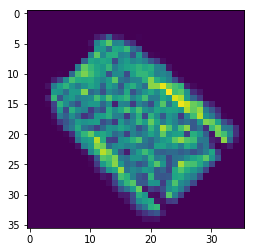

In [7]:
plt.imshow(cv2_rotate(pad(X_train[3501]), 45))

In [8]:
augmented_rotations_per_sample = 3
angle_step = 30
num_angles = 12

In [9]:
def generate_random_rotations(X, Y, n_rotations_per_sample):
    
    new_X = []
    new_Y = []
    rotations = []
    
    h, w = X.shape[1:]
    bigger = 2
    
    for image, label in tqdm(zip(X, Y), total=len(X)):
        
        image = pad(image)
        
        for _ in range(n_rotations_per_sample):
            
            rotation = np.random.randint(num_angles) * angle_step
            rotated_image = cv2_rotate(image, rotation)
            new_X.append(rotated_image)
            new_Y.append(label)
            rotations.append(rotation)
    
    new_X = np.array(new_X)
    if len(new_X.shape) == 3:
        new_X = np.expand_dims(new_X, 3)
        
    return new_X, np.array(new_Y), (np.array(rotations) / angle_step).astype(np.int)

In [10]:
nb_classes = keras.utils.to_categorical(Y_train).shape[1]

In [11]:
def create_rot_sin_cos(R_radians):
    rot_sin_cos = np.empty((len(R_radians), 2))
    rot_sin_cos[:, 0] = np.sin(R_radians)
    rot_sin_cos[:, 1] = np.cos(R_radians)
    return rot_sin_cos

In [12]:
from keras import layers
from keras import models
from keras import losses
import keras.backend as K

def cosine_proximity_unitary(y_true, y_pred):
    
    dot_product_loss = losses.cosine_proximity(y_true, y_pred)
    unit_circle_loss = K.square(1 - (K.square(y_pred[:, 0]) + K.square(y_pred[:, 1])))
    return dot_product_loss + 0.05 * unit_circle_loss


def build_model(use_labels=True, use_rotation=True, rot_range=-1):

    input_layer = layers.Input(X_train_rot.shape[1:], name='image_input')
    x = input_layer

    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.25)(x)
    flatten = layers.Flatten()(x)
    
    if use_labels:
        y = layers.Dense(128, activation='relu')(flatten)
        y = layers.Dropout(0.25)(y)
        y = layers.Dense(nb_classes, activation='softmax', name='y')(y)

    if use_rotation:
        r = layers.Dense(32, activation='relu')(flatten)
        r = layers.Dropout(0.5)(r)
        r = layers.Dense(num_angles, activation='softmax', name='r')(r)

    if use_labels and use_rotation:
        model = models.Model(input_layer, [y, r])        
        model.compile(optimizer='adam', loss=['categorical_crossentropy', 'categorical_crossentropy'], 
                      metrics={'y': 'accuracy', 'r': [keras_utils.angle_error, keras_utils.cos_error]},
                      loss_weights=[alpha, beta])
    elif use_labels:
        model = models.Model(input_layer, y)
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    elif use_rotation:
        model = models.Model(input_layer, r)
        model.compile(optimizer='adam', loss='cosine_proximity', metrics=['accuracy'])
    else:
        raise ValueError('Specify at least 1 output for the network!')
        
    #model.summary()
    
    return model

In [13]:
from keras import callbacks

class LossWeightsCallback(callbacks.Callback):
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
        
    # customize your behavior
    def on_epoch_end(self, epoch, logs={}):
        if epoch == 1:
            self.alpha = self.alpha - 0.4 # set to 0.5
            self.beta = self.beta + 0.4 # set to 0.5

In [14]:
def train_model(model, use_labels=True, use_rotation=True):
    
    if use_labels and use_rotation:
        y_train = [Y_train_onehot, R_train]
        y_test = [Y_test_onehot, R_test]
    elif use_labels:
        y_train = Y_train_onehot
        y_test = Y_test_onehot
    elif use_rotation:
        y_train = R_train
        y_test = R_test
    else:
        raise ValueError('Specify output for training')
        
    
    early_stopper = callbacks.EarlyStopping(patience=1)
    
    if use_labels and use_rotation:
        lw_callback = LossWeightsCallback(alpha, beta)
        _callbacks = [early_stopper, lw_callback]
    else:
        _callbacks = [early_stopper]
    
    return model.fit(X_train_rot, y_train, 
                     validation_data=(X_test_rot, y_test), 
                     callbacks=_callbacks,
                     batch_size=256,
                     epochs=10)

In [15]:
histories = []
diff_degrees = []
y_preds = []
r_preds = []

use_labels = True
use_rotation = True

X_train_rot, Y_train_rot, R_train = generate_random_rotations(X_train, Y_train, 
                                                              augmented_rotations_per_sample)
X_test_rot, Y_test_rot, R_test = generate_random_rotations(X_test, Y_test, 
                                                           augmented_rotations_per_sample)

R_train = keras.utils.to_categorical(R_train)
R_test = keras.utils.to_categorical(R_test)

Y_train_onehot = keras.utils.to_categorical(Y_train_rot)
Y_test_onehot = keras.utils.to_categorical(Y_test_rot)

nb_classes = Y_train_onehot.shape[1]

#R_train_radians, R_test_radians = (R * np.pi / 180 for R in (R_train, R_test))

#R_train_sin_cos = create_rot_sin_cos(R_train_radians)
#R_test_sin_cos = create_rot_sin_cos(R_test_radians)

alpha = K.variable(0.9)
beta = K.variable(0.1)
model = build_model(use_labels, use_rotation)

history = train_model(model, use_labels, use_rotation).history
histories.append(history)

Y_pred, R_pred = model.predict(X_test_rot)
R_test = np.argmax(R_test, axis=1) * angle_step
R_pred = np.argmax(R_pred, axis=1) * angle_step

diff_degree = np.abs(R_pred - R_test)
diff_degree = np.array([diff if diff < 180 else 360 - diff for diff in diff_degree])
print(np.mean(diff_degree))

diff_degrees.append(diff_degree)
y_preds.append(Y_pred)
r_preds.append(R_pred)


100%|██████████| 10000/10000 [00:00<00:00, 13323.71it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 35s 192us/step - loss: 1.5096 - y_loss: 1.5805 - r_loss: 0.8716 - y_acc: 0.6763 - r_angle_error: 1.2126 - r_cos_error: -0.9989 - val_loss: 0.5097 - val_y_loss: 0.5510 - val_r_loss: 0.1379 - val_y_acc: 0.8081 - val_r_angle_error: 0.2073 - val_r_cos_error: -0.9998
Epoch 2/10
180000/180000 [==============================] - 33s 186us/step - loss: 0.5403 - y_loss: 0.5592 - r_loss: 0.3698 - y_acc: 0.8005 - r_angle_error: 0.5653 - r_cos_error: -0.9995 - val_loss: 0.4302 - val_y_loss: 0.4658 - val_r_loss: 0.1102 - val_y_acc: 0.8329 - val_r_angle_error: 0.1740 - val_r_cos_error: -0.9998
Epoch 3/10
180000/180000 [==============================] - 33s 186us/step - loss: 0.4657 - y_loss: 0.4828 - r_loss: 0.3112 - y_acc: 0.8255 - r_angle_error: 0.4842 - r_cos_error: -0.9996 - val_loss: 0.3990 - val_y_loss: 0.4326 - val_r_loss: 0.0966 - val_y_acc: 0.8435 - val_r_angle_error: 0.1580 - val_r

In [16]:
def get_data_from_histories():

    for history in histories:

        idx_min_loss = np.argmin(history['val_loss'])
        data = []

        for key in ('val_loss', 'val_r_cos_error', 'val_r_angle_error', 'val_y_loss', 'val_y_acc'):
            data.append(history[key][idx_min_loss])
            
        yield data

In [17]:
data = np.array(list(get_data_from_histories()))

In [18]:
%matplotlib inline

import matplotlib.pyplot as plt

ValueError: x and y must have same first dimension, but have shapes (13,) and (1,)

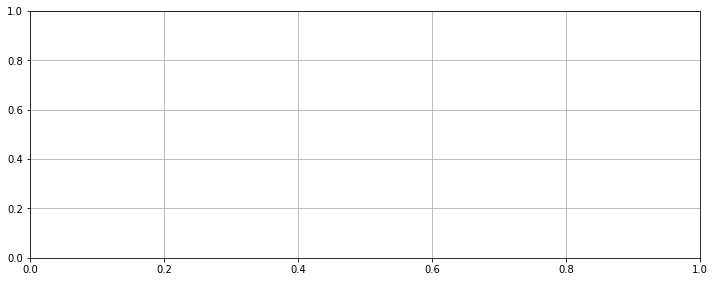

In [19]:
plt.figure(figsize=(12, 10))
plt.subplot(211)
plt.grid()
plt.plot(np.arange(10, 140, 10) * 2, data[:, 4][:13], label='classification_accuracy')
plt.xlabel('Rotation range (degrees)')
plt.legend()
plt.subplot(212)
plt.grid()
plt.plot(np.arange(10, 140, 10) * 2, data[:, 1][:13], label='rotation_loss')
plt.xlabel('Rotation range (degrees)')
plt.legend()

In [ ]:
diff_degrees = np.array(diff_degrees)

In [ ]:
w = np.mean(diff_degrees, axis=1)
print(w)

In [ ]:
np.percentile(diff_degrees, 99, axis=1)

In [ ]:
z = np.array([ 1.3832554 ,  1.77593382,  1.77201876,  1.92890577,  2.56119157,
        3.64702688,  4.17862631,  5.16323753,  5.82470787,  6.41361201,
        6.25119255,  7.47966726,  8.20807014,  8.64786822,  9.71438578,
        9.81888869, 10.68765806, 10.78373911])

NameError: name 'w' is not defined

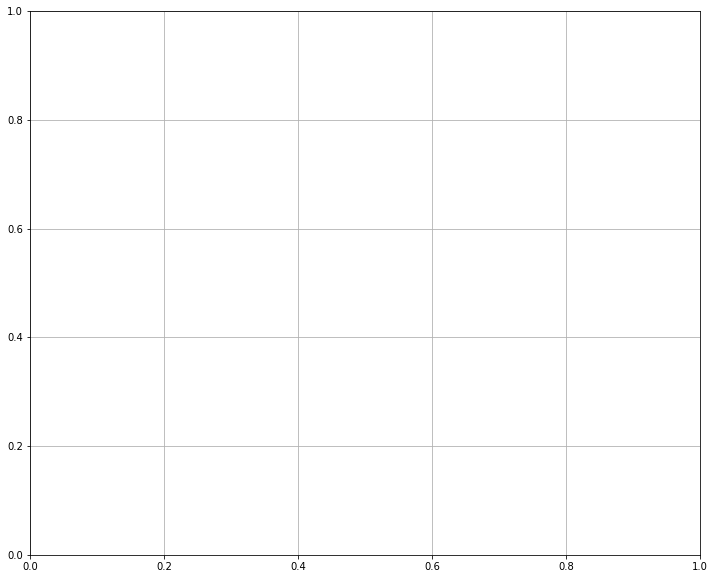

In [20]:
plt.figure(figsize=(12, 10))
plt.grid()
plt.plot(np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 150, 170, 180]) * 2,
          np.concatenate([w[:13], [w[14]], w[16:]]), label='categorical output')
plt.plot(np.arange(10, 190, 10) * 2, z, label='sin-cos output')
plt.xlabel('Rotation range')
plt.ylabel('Mean difference between true and predicted orientation')
plt.legend()
plt.title('Mean difference between true and predicted orientations (in degrees) as a function of the\nrotation range of the Fashion MNIST samples.\nTwo network configurations have been tested for predicting the orientation of a sample;\nthe first uses a 2 values sin and cos output trained using dot product loss; the second is a classification output, with one\n output for each degree (the number of outputs grows with the rotation range)')

In [ ]:
Y_pred, R_pred = model.predict(X_test_rot)

In [ ]:
diff_degree = np.abs(np.arctan2(R_pred[:, 0], R_pred[:, 1]) * 180 / np.pi - R_test)
diff_degree = np.array([diff if diff < 180 else diff - 180 for diff in diff_degree])
print(np.mean(diff_degree))

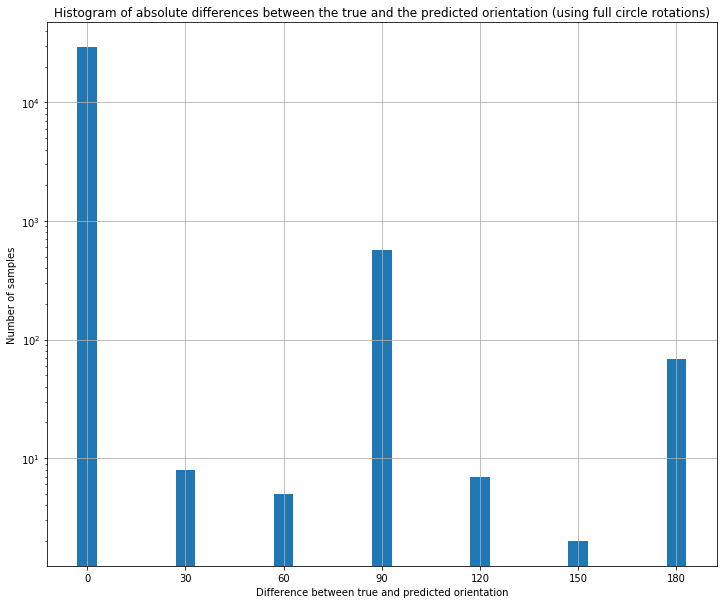

In [21]:
plt.figure(figsize=(12, 10))
plt.title('Histogram of absolute differences between the true and the predicted orientation (using full circle rotations)')
#plt.hist(diff_degree, bins=50)
plt.bar([0, 30, 60, 90, 120, 150, 180], [np.count_nonzero(diff_degree == x) for x in [0, 30, 60, 90, 120, 150, 180]], width=6)
plt.grid()
plt.xlabel('Difference between true and predicted orientation')
plt.ylabel('Number of samples')
plt.yscale('log')
plt.xticks([0, 30, 60, 90, 120, 150, 180])
plt.show()

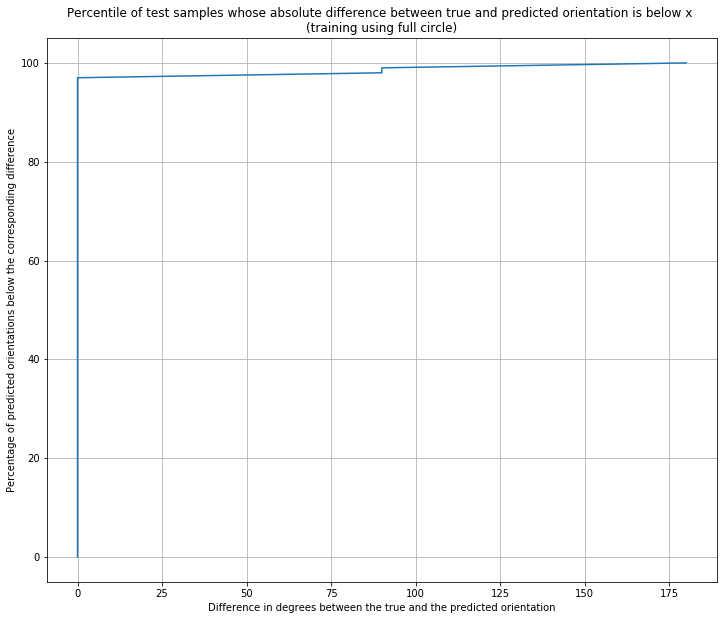

In [22]:
xv = np.arange(0, 101)
plt.figure(figsize=(12, 10))
plt.grid()
plt.plot([np.percentile(diff_degree, x) for x in xv], xv)
plt.title('Percentile of test samples whose absolute difference between true and predicted orientation is below x \n(training using full circle)')
plt.xlabel('Difference in degrees between the true and the predicted orientation')
plt.ylabel('Percentage of predicted orientations below the corresponding difference')
plt.show()

In [ ]:
Y_pred = np.argmax(Y_pred, axis=1)

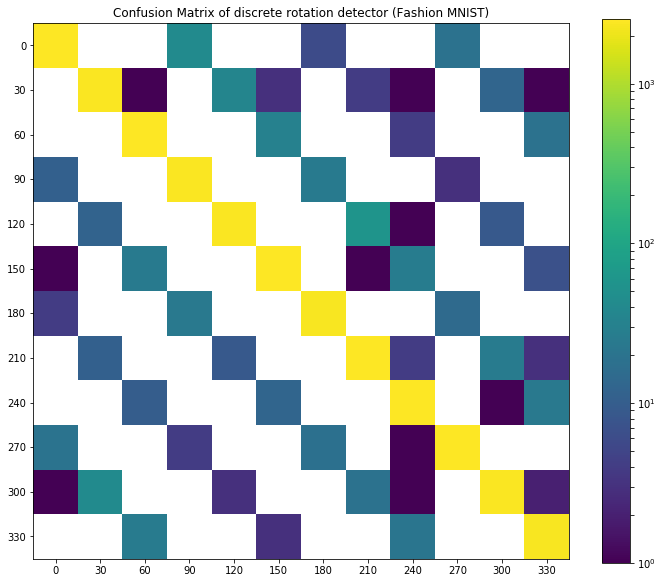

In [23]:
confusion_matrix = np.zeros((12, 12), dtype='int')
r_pred, r_test = R_pred // angle_step, R_test // angle_step

from matplotlib.colors import LogNorm

for y_true, y_pred in zip(r_test, r_pred):
    confusion_matrix[y_true, y_pred] += 1

plt.figure(figsize=(12, 10))
plt.title('Confusion Matrix of discrete rotation detector (Fashion MNIST)')
plt.imshow(confusion_matrix, norm=LogNorm())
plt.xticks(np.arange(12), np.arange(0, 360, 30))
plt.yticks(np.arange(12), np.arange(0, 360, 30))
plt.colorbar()